In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import time
import requests
import warnings
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score


# Suppress warnings
warnings.filterwarnings("ignore")

# Load the data
url = "https://data.cityofchicago.org/resource/crimes.json"
params = {"$where": "year >= '2023'", "$limit": 17000}
response = requests.get(url, params=params)
df = pd.json_normalize(response.json())

df

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,fbi_code,x_coordinate,y_coordinate,year,updated_on,latitude,longitude,location.latitude,location.longitude,location.human_address
0,13204489,JG416325,2023-09-06T11:00:00.000,0000X E 8TH ST,0810,THEFT,OVER $500,PARKING LOT / GARAGE (NON RESIDENTIAL),False,False,...,06,1176857,1896680,2023,2023-11-04T15:40:18.000,41.871834768,-87.62615082,41.871834768,-87.62615082,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
1,13045102,JG226663,2023-03-30T09:16:00.000,080XX S DREXEL AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,APARTMENT,False,True,...,17,1183631,1851847,2023,2023-09-14T15:41:59.000,41.748653803,-87.602680492,41.748653803,-87.602680492,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
2,13074891,JG262771,2023-05-10T12:43:00.000,028XX N MANGO AVE,1754,OFFENSE INVOLVING CHILDREN,AGGRAVATED SEXUAL ASSAULT OF CHILD BY FAMILY M...,RESIDENCE,False,True,...,02,1137557,1918320,2023,2023-09-14T15:41:59.000,41.932015426,-87.769916668,41.932015426,-87.769916668,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
3,13099339,JG291745,2023-04-01T11:13:00.000,020XX N LAPORTE AVE,1751,OFFENSE INVOLVING CHILDREN,CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER,RESIDENCE,False,True,...,17,1143059,1913090,2023,2023-09-14T15:41:59.000,41.917562778,-87.749828117,41.917562778,-87.749828117,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
4,13121127,JG313964,2023-06-22T18:52:00.000,015XX W NORTH AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,AUTO / BOAT / RV DEALERSHIP,True,False,...,11,1165854,1910738,2023,2023-09-14T15:41:59.000,41.91065261,-87.66614577,41.91065261,-87.66614577,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,13226506,JG443096,2023-09-28T23:08:00.000,071XX S INDIANA AVE,0810,THEFT,OVER $500,STREET,False,False,...,06,1178838,1857746,2023,2023-10-06T15:43:01.000,41.764951664,-87.620064404,41.764951664,-87.620064404,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
16996,13225395,JG441907,2023-09-28T01:58:00.000,011XX S TROY ST,0560,ASSAULT,SIMPLE,APARTMENT,False,True,...,08A,1155533,1894984,2023,2023-10-06T15:43:01.000,41.867636169,-87.704485536,41.867636169,-87.704485536,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
16997,13226002,JG442565,2023-09-28T14:23:00.000,051XX W CONCORD PL,051A,ASSAULT,AGGRAVATED - HANDGUN,SIDEWALK,True,False,...,04A,1142030,1910489,2023,2023-10-06T15:43:01.000,41.9104445,-87.753673327,41.9104445,-87.753673327,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."
16998,13226464,JG443005,2023-09-28T09:40:00.000,048XX N WINTHROP AVE,0560,ASSAULT,SIMPLE,RESIDENCE - PORCH / HALLWAY,False,True,...,08A,1168000,1932319,2023,2023-10-06T15:43:01.000,41.969825789,-87.657637278,41.969825789,-87.657637278,"{""address"": """", ""city"": """", ""state"": """", ""zip""..."


# Data Preprocessing :

In [18]:
# Preprocess the data
start_time = time.time()
df = df.dropna()

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract the month and hour information from the 'date' column
df['month'] = df['date'].dt.month
df['hour'] = df['date'].dt.hour

# Define hour ranges
hour_ranges = {
    (0, 1): '12 am - 01 am',
    (1, 2): '01 am - 02 am',
    (2, 3): '02 am - 03 am',
    (3, 4): '03 am - 04 am',
    (4, 5): '04 am - 05 am',
    (5, 6): '05 am - 06 am',
    (6, 7): '06 am - 07 am',
    (7, 8): '07 am - 08 am',
    (8, 9): '08 am - 09 am',
    (9, 10): '09 am - 10 am',
    (10, 11): '10 am - 11 am',
    (11, 12): '11 am - 12 pm',
    (12, 13): '12 pm - 01 pm',
    (13, 14): '01 pm - 02 pm',
    (14, 15): '02 pm - 03 pm',
    (15, 16): '03 pm - 04 pm',
    (16, 17): '04 pm - 05 pm',
    (17, 18): '05 pm - 06 pm',
    (18, 19): '06 pm - 07 pm',
    (19, 20): '07 pm - 08 pm',
    (20, 21): '08 pm - 09 pm',
    (21, 22): '09 pm - 10 pm',
    (22, 23): '10 pm - 11 pm',
    (23, 24): '11 pm - 12 am'
}

# Assign the hour range based on the 'hour' column
df['hour_range'] = df['hour'].apply(lambda x: next((v for k, v in hour_ranges.items() if x >= k[0] and x < k[1]), np.nan))

df['season'] = (df['month'] % 12 + 3) // 3
df = df[['primary_type', 'block', 'arrest', 'domestic', 'month', 'hour_range', 'season']]

df['block'] = df['block'].str[6:]  # Trim the first six letters of the block column
df['location_name'] = df['block']

def arrest_domestic(row):
    if row['arrest'] == True and row['domestic'] == True:
        return 'Arrest Domestic'
    elif row['arrest'] == False and row['domestic'] == True:
        return 'Non-Arrest Domestic'
    elif row['arrest'] == True and row['domestic'] == False:
        return 'Arrest Non-Domestic'
    else:
        return 'Non-Arrest Non-Domestic'

# Add the 'arrest_domestic' column to the main DataFrame
df['arrest_domestic'] = df.apply(lambda row: arrest_domestic(row), axis=1)

# Update the list of columns in the DataFrame
df = df[['primary_type', 'location_name', 'month', 'hour_range', 'season', 'arrest_domestic']]

print(f"Preprocessed {len(df)} records in {time.time() - start_time:.2f} seconds.")

# Perform EDA and ML based on the preprocessed data (similar to the previous code)



Preprocessed 16931 records in 0.13 seconds.


In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from itertools import product

# Load preprocessed data
# df = pd.read_csv('preprocessed_data.csv')

# Encode categorical variables
le_location = LabelEncoder()
le_hour_range = LabelEncoder()
le_primary_type = LabelEncoder()
le_arrest_domestic = LabelEncoder()

df['location_name_encoded'] = le_location.fit_transform(df['location_name'])
df['hour_range_encoded'] = le_hour_range.fit_transform(df['hour_range'])
df['primary_type_encoded'] = le_primary_type.fit_transform(df['primary_type'])
df['arrest_domestic_encoded'] = le_arrest_domestic.fit_transform(df['arrest_domestic'])

# Split the dataset
features = ['location_name_encoded', 'month', 'hour_range_encoded', 'season']
target_arrest = 'arrest_domestic_encoded'
target_primary_type = 'primary_type_encoded'

# Remove classes with only one instance
primary_type_counts = df['primary_type'].value_counts()
primary_types_to_remove = primary_type_counts[primary_type_counts == 1].index

# Remove rows with the primary types to remove
df_filtered = df[~df['primary_type'].isin(primary_types_to_remove)]




In [20]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16931 entries, 0 to 16999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   primary_type             16931 non-null  object
 1   location_name            16931 non-null  object
 2   month                    16931 non-null  int64 
 3   hour_range               16931 non-null  object
 4   season                   16931 non-null  int64 
 5   arrest_domestic          16931 non-null  object
 6   location_name_encoded    16931 non-null  int64 
 7   hour_range_encoded       16931 non-null  int64 
 8   primary_type_encoded     16931 non-null  int64 
 9   arrest_domestic_encoded  16931 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 1.4+ MB


In [21]:
df_filtered.describe()

,month,season,location_name_encoded,hour_range_encoded,primary_type_encoded,arrest_domestic_encoded
count,16931.000000,16931.000000,16931.000000,16931.000000,16931.000000,16931.000000
mean,8.860020,3.918434,756.838698,12.396728,12.578584,2.582482
std,0.755615,0.340802,366.688473,7.093487,9.566907,0.763984
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,4.000000,492.000000,6.000000,2.000000,2.000000
50%,9.000000,4.000000,741.000000,13.000000,15.000000,3.000000
75%,9.000000,4.000000,1060.000000,19.000000,23.000000,3.000000
max,11.000000,4.000000,1422.000000,23.000000,26.000000,3.000000


In [22]:
def plot_histogram(data,columns):
  fig,axes=plt.subplots(nrows=len(columns),ncols=1,figsize=(20,20))
  for i,col in enumerate(columns):
    sns.histplot(data[col],kde=False,ax=axes[i])
    axes[i].set_xlabel(col)
  plt.tight_layout()
  plt.show()

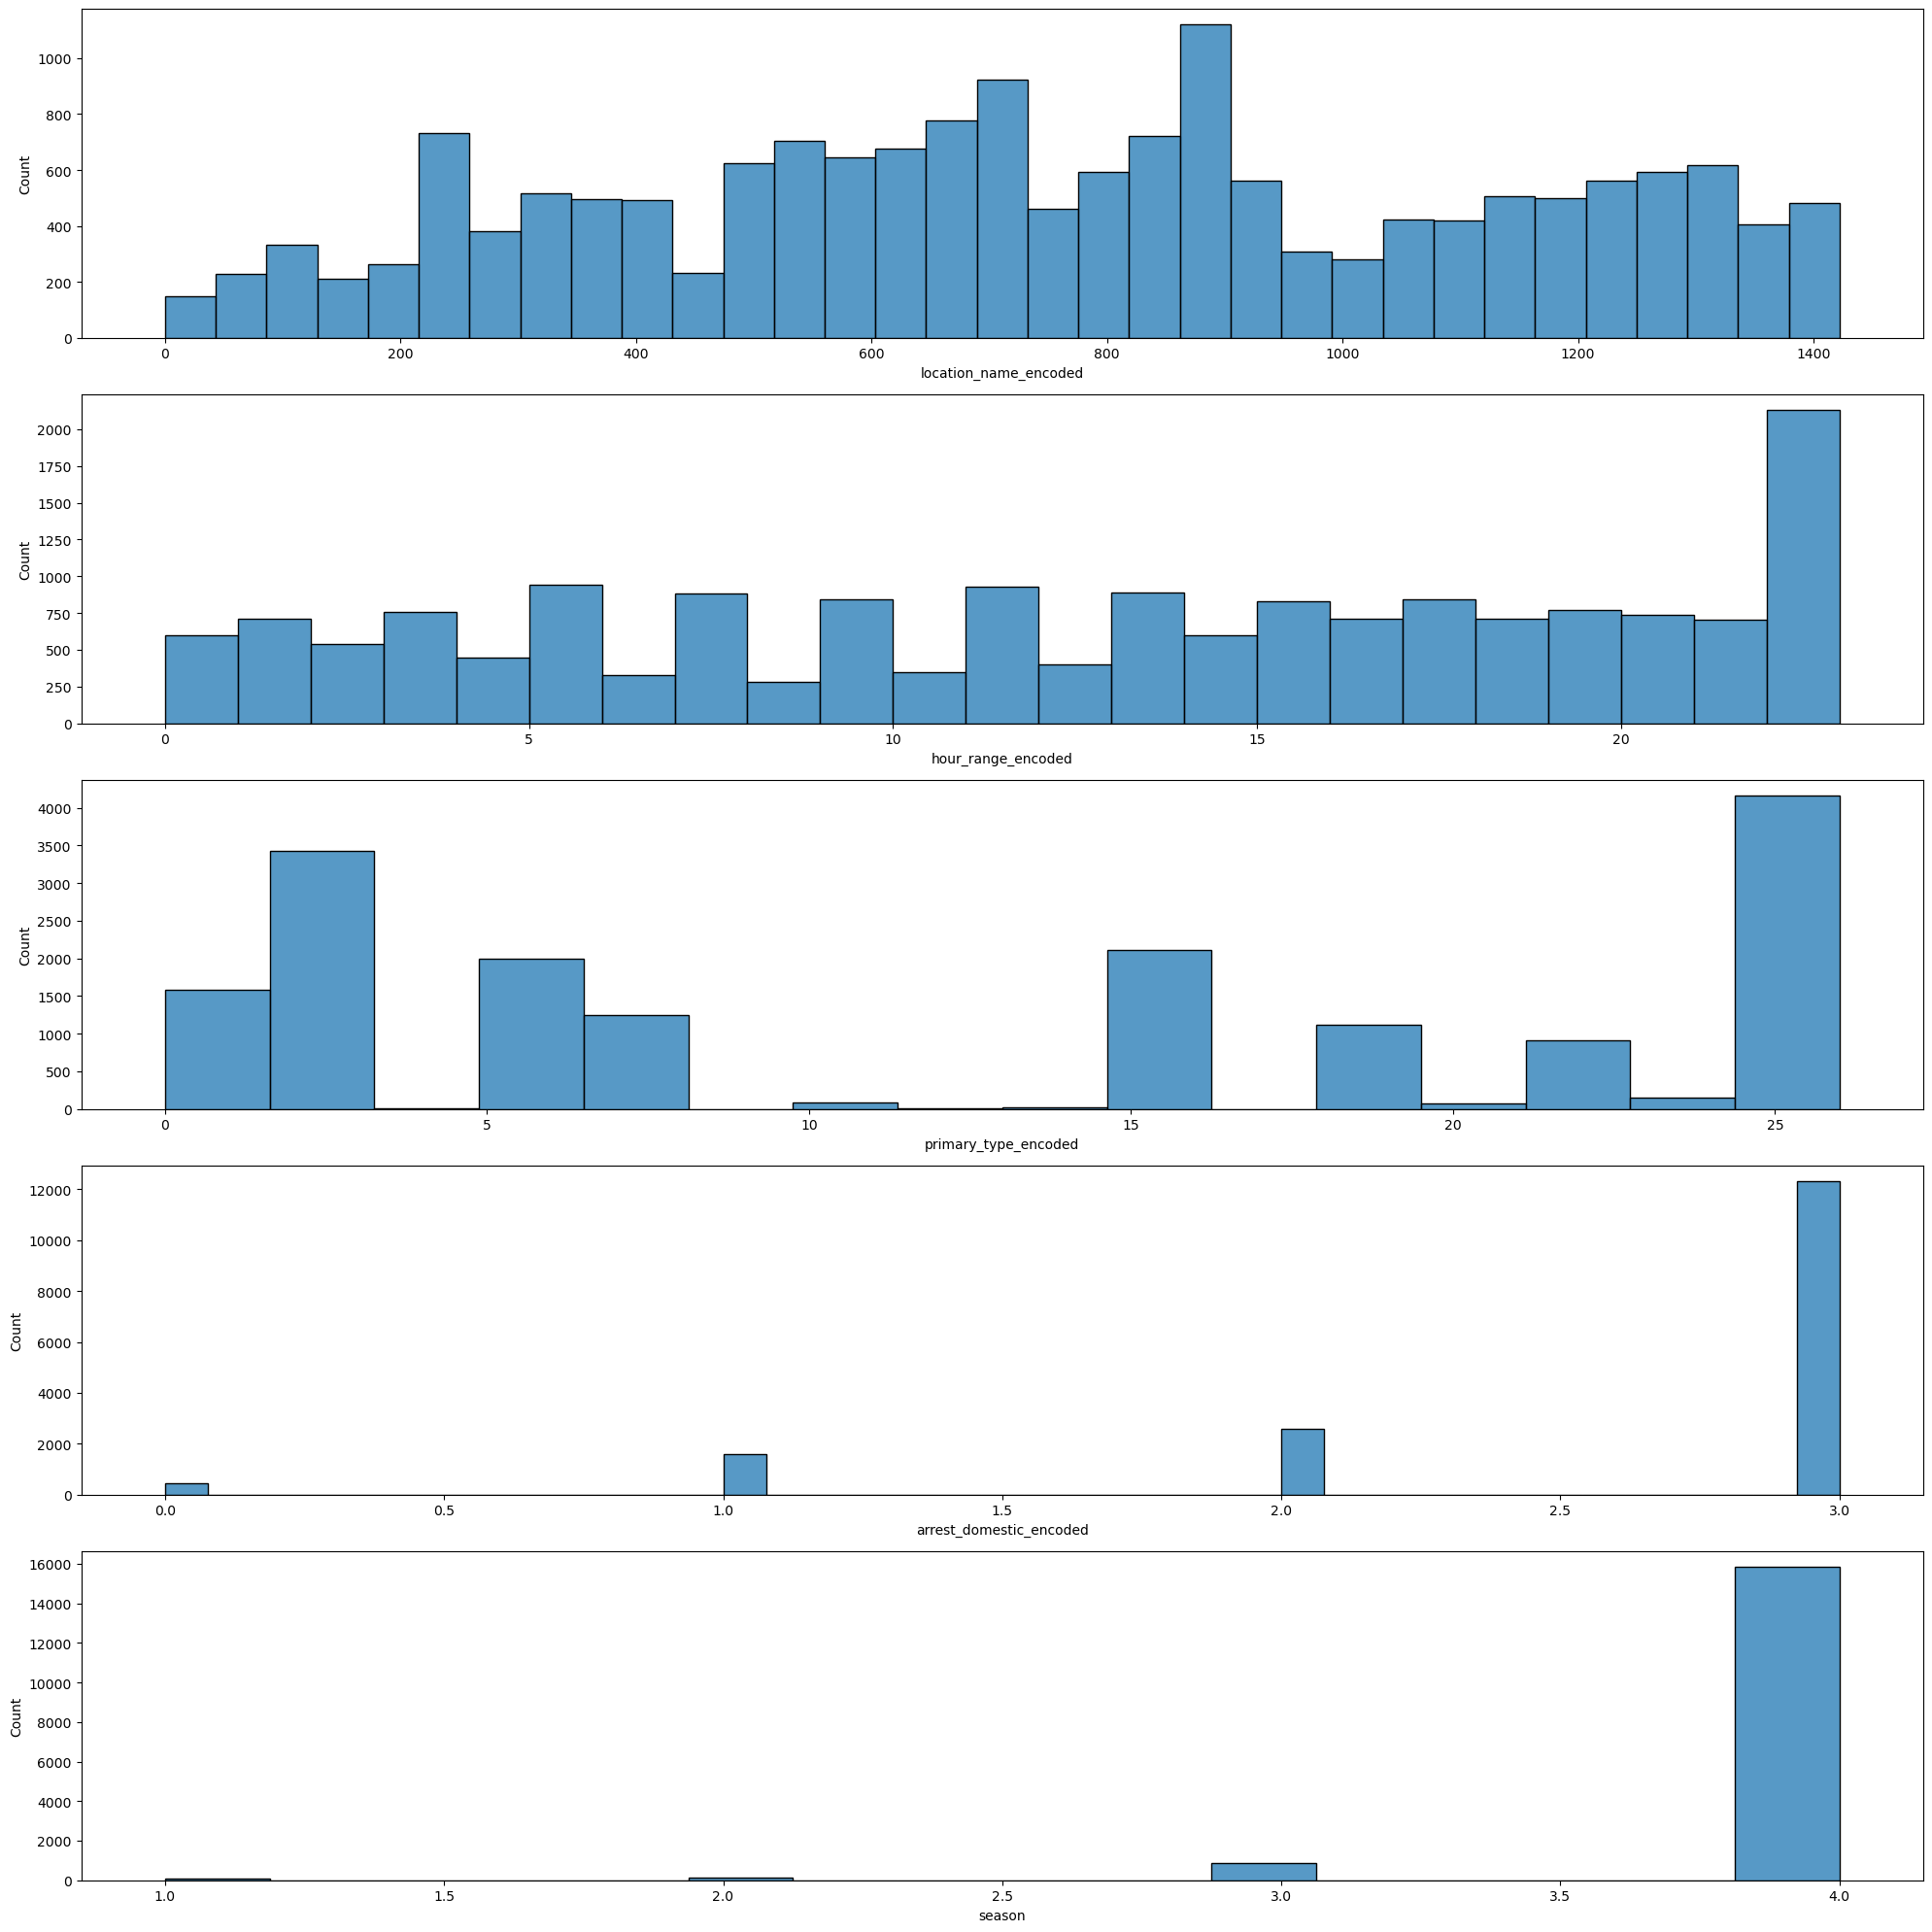

In [23]:
col=['location_name_encoded','hour_range_encoded','primary_type_encoded','arrest_domestic_encoded','season']
plot_histogram(df_filtered,col)

<Axes: >

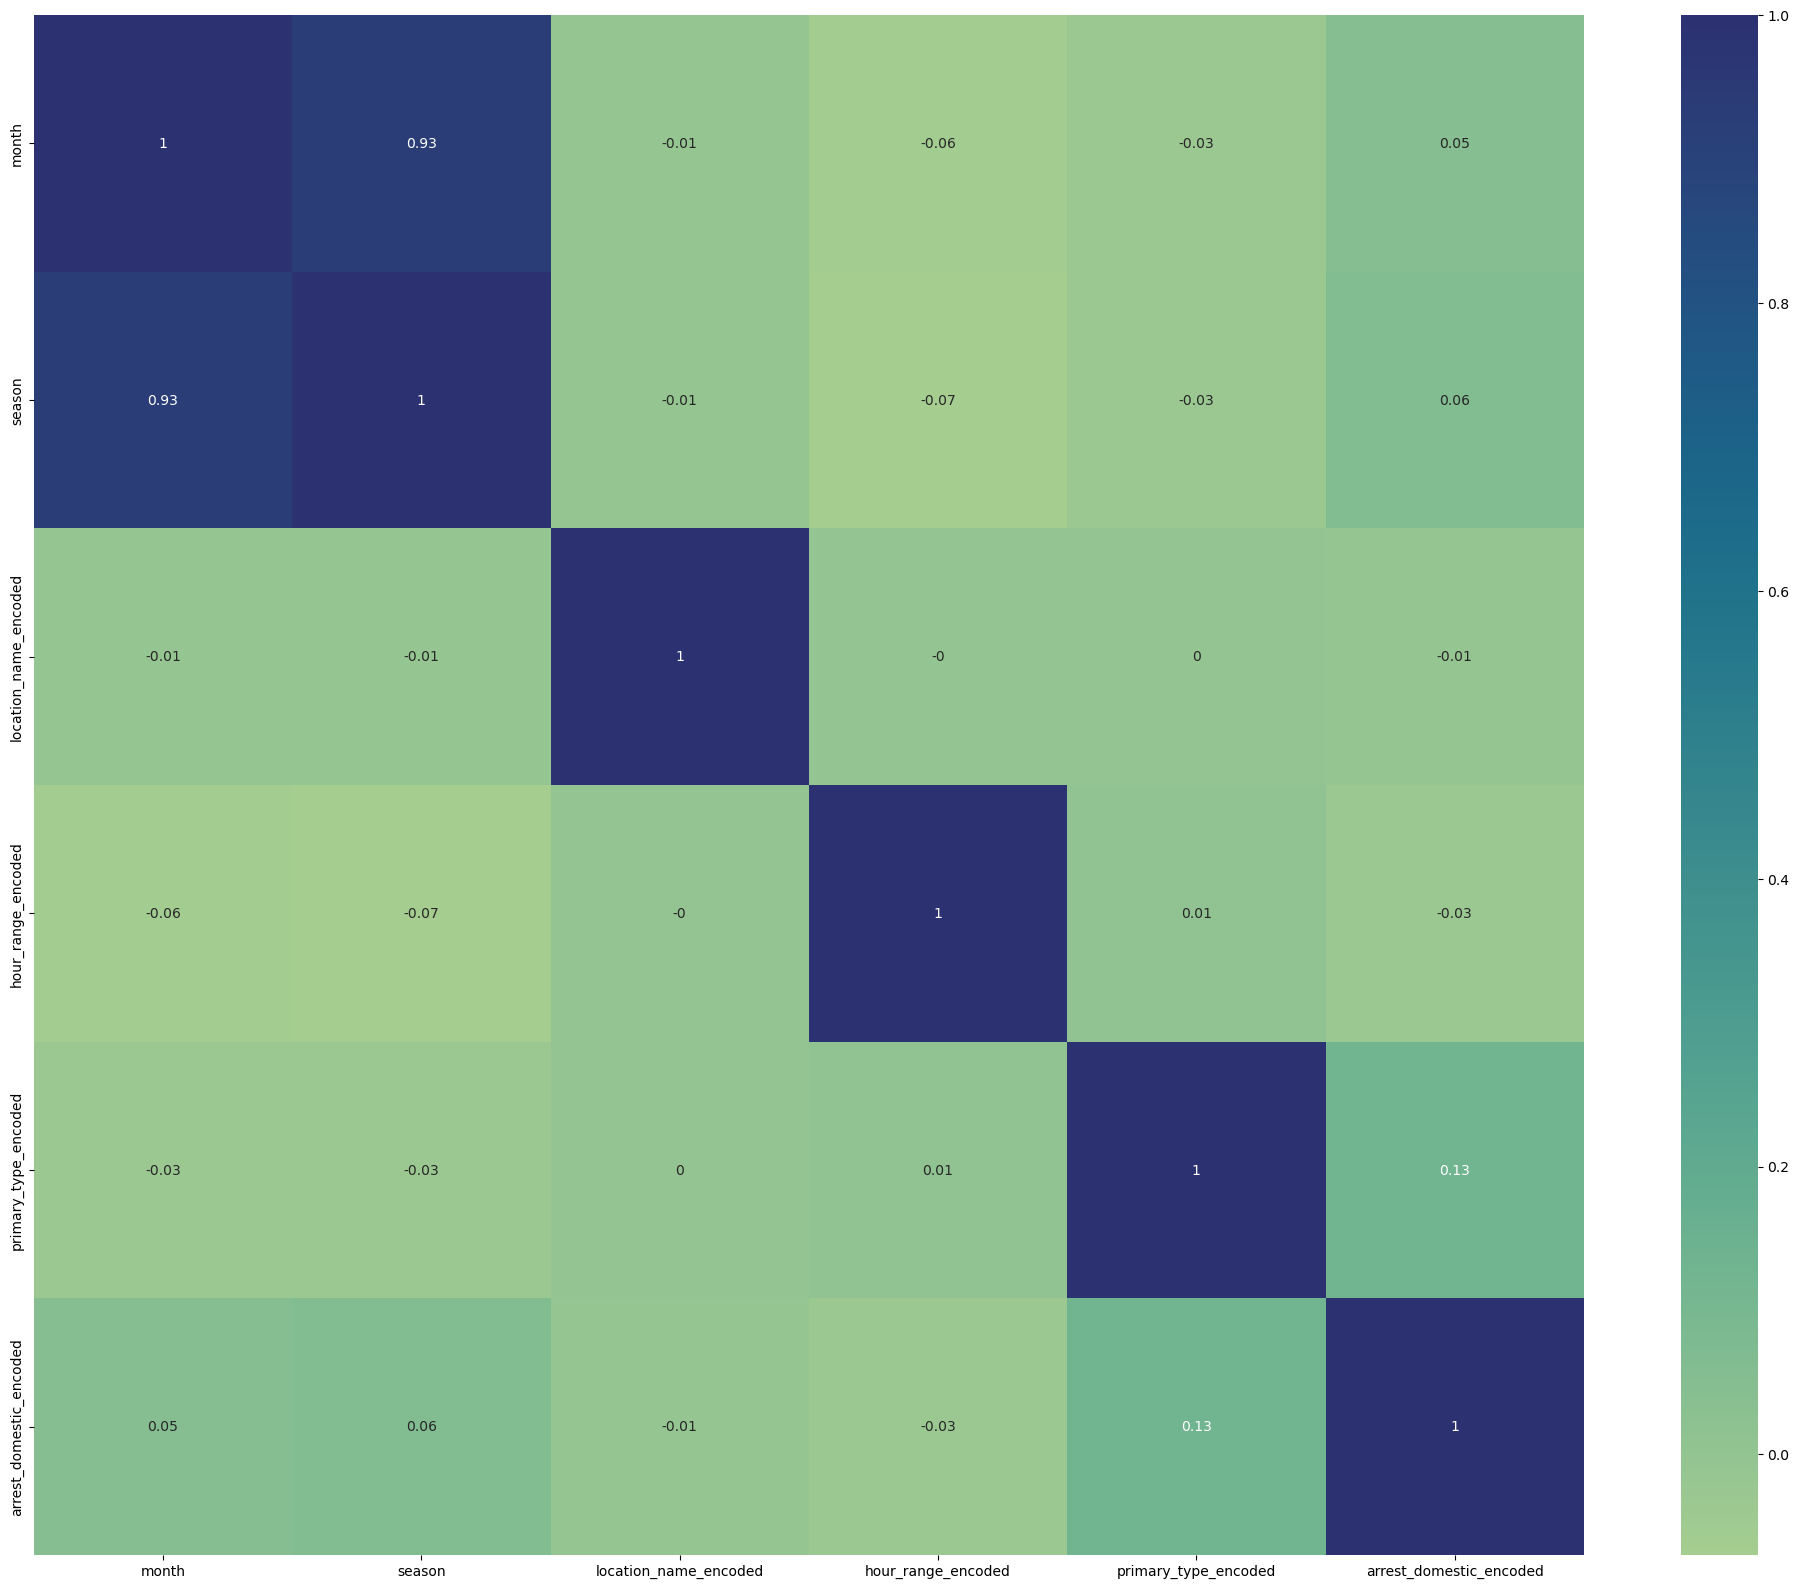

In [24]:
correlation_between_columns = df_filtered.corr().round(2)
plt.figure(figsize = (25,20))
sns.heatmap(correlation_between_columns, annot = True, cmap = 'crest')

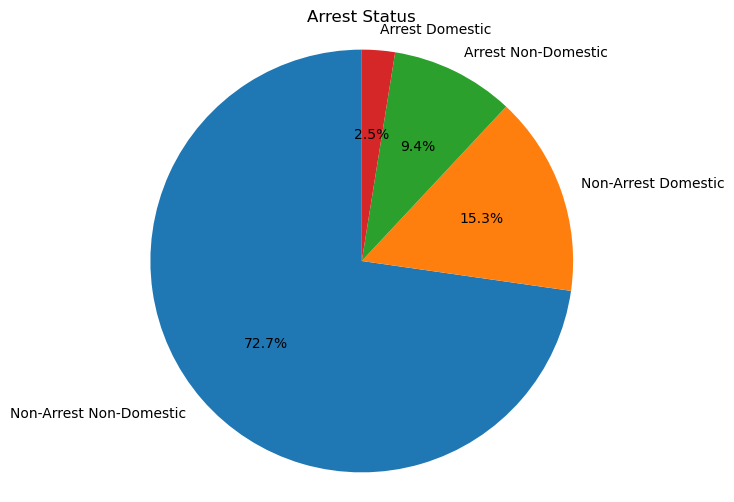

In [25]:
plt.figure(figsize=(6,6))
status_counts=df_filtered['arrest_domestic_encoded'].value_counts()
labels=["Non-Arrest Non-Domestic","Non-Arrest Domestic","Arrest Non-Domestic","Arrest Domestic"]
plt.pie(status_counts,labels=labels,startangle=90,autopct='%.1f%%')
plt.title("Arrest Status")
plt.axis('equal')
plt.show()

# Data Split into Train, Validation and Test :

In [26]:
X = df_filtered[features]
y_arrest = df_filtered[target_arrest]
y_primary_type = df_filtered[target_primary_type]


X_train_arrest, X_temp, y_train_arrest, Y_temp = train_test_split(X, y_arrest, train_size=0.6, stratify=y_arrest,random_state=42)
X_val_arrest, X_test_arrest, y_val_arrest, y_test_arrest = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp,random_state=42)


X_train_primary, X_temp_primary, y_train_primary, Y_temp_primary = train_test_split(X, y_primary_type, train_size=0.6, stratify=y_primary_type,random_state=42)
X_val_primary, X_test_primary, y_val_primary, y_test_primary = train_test_split(X_temp_primary, Y_temp_primary, test_size=0.5, stratify=Y_temp,random_state=42)


# Model Selection :

# Random Forest :

In [27]:
random_forest_arrest_model = RandomForestClassifier(n_estimators = 100, max_depth = 10)
random_forest_arrest_model.fit(X_train_arrest,y_train_arrest)
Y_pred_random_forest_arrest = random_forest_arrest_model.predict(X_val_arrest)
random_forest_arrest_accuracy = accuracy_score(y_val_arrest,Y_pred_random_forest_arrest)
print(f"Accuracy Score:{random_forest_arrest_accuracy}")
random_forest_arrest_f1_score = f1_score(y_val_arrest, Y_pred_random_forest_arrest, average='weighted')
print(f"F1 Score is:{random_forest_arrest_f1_score}")


Accuracy Score:0.7265209686946249
F1 Score is:0.6171479307931933


In [28]:
random_forest_primary_model = RandomForestClassifier(n_estimators = 100, max_depth = 10)
random_forest_primary_model.fit(X_train_primary,y_train_primary)
Y_pred_random_forest_primary = random_forest_primary_model.predict(X_val_primary)
random_forest_primary_accuracy = accuracy_score(y_val_primary,Y_pred_random_forest_primary)
print(f"Accuracy Score:{random_forest_primary_accuracy}")
random_forest_primary_f1_score = f1_score(y_val_primary, Y_pred_random_forest_primary, average='weighted')
print(f"F1 Score is:{random_forest_primary_f1_score}")

Accuracy Score:0.23095097460129946
F1 Score is:0.15475519064025767


# Decision Tree Model :

In [29]:
decision_tree_arrest_model = DecisionTreeClassifier()
decision_tree_arrest_model.fit(X_train_arrest,y_train_arrest)
Y_pred_decision_tree_arrest = decision_tree_arrest_model.predict(X_val_arrest)
decision_tree_arrest_accuracy = accuracy_score(y_val_arrest,Y_pred_decision_tree_arrest)
print(f"Accuracy Score:{decision_tree_arrest_accuracy}")
decision_tree_arrest_f1_score = f1_score(y_val_arrest, Y_pred_decision_tree_arrest, average='weighted')
print(f"F1 Score:{decision_tree_arrest_f1_score}")

Accuracy Score:0.5699940933254578
F1 Score:0.5758767367770508


In [30]:
decision_tree_primary_model = DecisionTreeClassifier()
decision_tree_primary_model.fit(X_train_primary,y_train_primary)
Y_pred_decision_tree_primary = decision_tree_primary_model.predict(X_val_primary)
decision_tree_primary_accuracy = accuracy_score(y_val_primary,Y_pred_decision_tree_primary)
print(f"Accuracy Score:{decision_tree_primary_accuracy}")
decision_tree_primary_f1_score = f1_score(y_val_primary, Y_pred_decision_tree_primary, average='weighted')
print(f"F1 Score:{decision_tree_primary_f1_score}")

Accuracy Score:0.15445953927938572
F1 Score:0.15322237687367754


# XGBoost Model :

In [31]:
xgb_arrest_model=XGBClassifier(n_estimators=800,learning_rate=0.1)
xgb_arrest_model.fit(X_train_arrest,y_train_arrest)
Y_pred_xgb_arrest = xgb_arrest_model.predict(X_val_arrest)
xgb_accuracy_arrest = accuracy_score(y_val_arrest,Y_pred_xgb_arrest)
print(f"Accuracy Score:{xgb_accuracy_arrest}")
xgb_f1_score_arrest = f1_score(y_val_arrest, Y_pred_xgb_arrest, average='weighted')
print(f"F1 Score:{xgb_f1_score_arrest}")

Accuracy Score:0.7049616066154755
F1 Score:0.6197694222925708


In [32]:
xgb_primary_model=XGBClassifier(n_estimators=800,learning_rate=0.1)
xgb_primary_model.fit(X_train_primary,y_train_primary)
Y_pred_xgb_primary = xgb_primary_model.predict(X_val_primary)
xgb_accuracy_primary = accuracy_score(y_val_primary,Y_pred_xgb_primary)
print(f"Accuracy Score:{xgb_accuracy_primary}")
xgb_f1_score_primary = f1_score(y_val_primary, Y_pred_xgb_primary, average='weighted')
print(f"F1 Score:{xgb_f1_score_primary}")

Accuracy Score:0.19787359716479622
F1 Score:0.17861079089898485


# KNN Model :

In [33]:
knn_arrest_model=KNeighborsClassifier(n_neighbors=16)
knn_arrest_model.fit(X_train_arrest,y_train_arrest)
Y_pred_knn_arrest = knn_arrest_model.predict(X_val_arrest)
knn_accuracy_arrest = accuracy_score(y_val_arrest,Y_pred_knn_arrest)
print(f"Accuracy Score:{knn_accuracy_arrest}")
knn_f1_score_arrest = f1_score(y_val_arrest, Y_pred_knn_arrest, average='weighted')
print(f"F1 Score:{knn_f1_score_arrest}")

Accuracy Score:0.7244536326048435
F1 Score:0.6198997453340289


In [34]:
knn_primary_model=KNeighborsClassifier(n_neighbors=16)
knn_primary_model.fit(X_train_primary,y_train_primary)
Y_pred_knn_primary = knn_primary_model.predict(X_val_primary)
knn_accuracy_primary = accuracy_score(y_val_primary,Y_pred_knn_primary)
print(f"Accuracy Score:{knn_accuracy_primary}")
knn_f1_score_primary = f1_score(y_val_primary, Y_pred_knn_primary, average='weighted')
print(f"F1 Score:{knn_f1_score_primary}")

Accuracy Score:0.19432959243945658
F1 Score:0.1620574651303493


# Cross-Validation :

In [35]:
models = [
    ('Random Forest', random_forest_arrest_model),
    ('Decision Tree', decision_tree_arrest_model),
    ('XGBoost', xgb_arrest_model),
    ('KNeighbors Classifier', knn_arrest_model)
]

# Iterate through each model and perform cross-validation
for model_name, model in models:
    # Perform cross-validation with 5 folds
    cv_scores = cross_val_score(model, X_val_arrest, y_val_arrest, cv=5)
    
    print(f"Model: {model_name}")
    print("Cross-validation scores:", cv_scores)
    print("Mean CV Accuracy:", cv_scores.mean())
    print("==============================")

Model: Random Forest
Cross-validation scores: [0.71828909 0.71935007 0.7267356  0.72082718 0.7282127 ]
Mean CV Accuracy: 0.72268292789201
Model: Decision Tree
Cross-validation scores: [0.55309735 0.5450517  0.58345643 0.53618907 0.57902511]
Mean CV Accuracy: 0.5593639298832696
Model: XGBoost
Cross-validation scores: [0.64896755 0.65140325 0.6676514  0.66026588 0.67799114]
Mean CV Accuracy: 0.6612558441501853
Model: KNeighbors Classifier
Cross-validation scores: [0.72271386 0.72082718 0.7267356  0.7267356  0.7282127 ]
Mean CV Accuracy: 0.7250449885186687


# Hyperparameter Tunning :

# Random Forest :

# Arrest Model :

In [36]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 20)
}


random_search = RandomizedSearchCV(estimator=random_forest_arrest_model, param_distributions=param_dist, n_iter=100, cv=5)


random_search.fit(X_val_arrest, y_val_arrest)

# Get the best parameters and the best score
best_params_rand = random_search.best_params_
best_score_rand = random_search.best_score_

print("Best Parameters (Randomized Search):", best_params_rand)
print("Best Score (Randomized Search):", best_score_rand)

Best Parameters (Randomized Search): {'max_depth': 5, 'n_estimators': 824}
Best Score (Randomized Search): 0.7282933120699947


# Primary Model :

In [ ]:
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 20)
}


random_search = RandomizedSearchCV(estimator=random_forest_primary_model, param_distributions=param_dist, n_iter=100, cv=5)


random_search.fit(X_val_primary, y_val_primary)

# Get the best parameters and the best score
best_params_rand = random_search.best_params_
best_score_rand = random_search.best_score_

print("Best Parameters (Randomized Search):", best_params_rand)
print("Best Score (Randomized Search):", best_score_rand)

# KNeighbors :

# Arrest Model :

In [ ]:
param_dist = {
    'n_neighbors': randint(1, 50),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for Minkowski distance
}



# Perform randomized search using RandomizedSearchCV
random_search = RandomizedSearchCV(
    knn_arrest_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,  # Number of cross-validation folds
    scoring='accuracy',  # Evaluation metric
    random_state=42  # Random seed for reproducibility
)

# Fit the randomized search to your data
random_search.fit(X_val_arrest, y_val_arrest)  # Replace X_train and y_train with your data

# Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

# Primary Model :

In [ ]:
param_dist = {
    'n_neighbors': randint(1, 50),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for Minkowski distance
}



# Perform randomized search using RandomizedSearchCV
random_search = RandomizedSearchCV(
    knn_primary_model,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,  # Number of cross-validation folds
    scoring='accuracy',  # Evaluation metric
    random_state=42  # Random seed for reproducibility
)

# Fit the randomized search to your data
random_search.fit(X_val_primary, y_val_primary)  # Replace X_train and y_train with your data

# Print the best parameters and best score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

# Confusion Matrix :

In [ ]:
Y_pred_random_forest_arrest = random_forest_arrest_model.predict(X_test_arrest)
cm = confusion_matrix(y_test_arrest, Y_pred_random_forest_arrest)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=["Non-Arrest Non-Domestic","Non-Arrest Domestic","Arrest Non-Domestic","Arrest Domestic"], 
            yticklabels=["Non-Arrest Non-Domestic","Non-Arrest Domestic","Arrest Non-Domestic","Arrest Domestic"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Final Prediction :

In [ ]:
unique_location_hour_range = df[['location_name', 'hour_range']].drop_duplicates().values


# Define function to predict probabilities for unique combinations
def predict_all_combinations(clf_arrest, clf_primary_type, unique_location_hour_range):
    all_months = range(1, 13)
    all_seasons = range(1, 5)

    results = []

    for location, time_range in unique_location_hour_range:
        for month, season in product(all_months, all_seasons):
            location_encoded = le_location.transform([location])[0]
            hour_range_encoded = le_hour_range.transform([time_range])[0]

            input_data = np.array([location_encoded, month, hour_range_encoded, season]).reshape(1, -1)

            arrest_prob = clf_arrest.predict_proba(input_data)[0]
            primary_type_prob = clf_primary_type.predict_proba(input_data)[0]

            result = {
                'location': location,
                'time_range': time_range,
                'month': month,
                'season': season,
                'arrest_domestic': arrest_prob[0],
                'non_arrest_domestic': arrest_prob[1],
                'arrest_non_domestic': arrest_prob[2],
                'non_arrest_non_domestic': arrest_prob[3],
            }

            top_10_primary_type_indices = np.argsort(primary_type_prob)[-10:]
            top_10_primary_type_probs = primary_type_prob[top_10_primary_type_indices]
            top_10_primary_types = le_primary_type.inverse_transform(top_10_primary_type_indices)

            print(f"\nLocation: {location} - Time Range: {time_range} - Month: {month} - Season: {season}")
            print("Top 10 Primary Types with Probabilities:")
            for primary_type, prob in zip(top_10_primary_types, top_10_primary_type_probs):
                result[f'primary_type_{primary_type}'] = prob
                print(f"{primary_type}: {prob*100:.2f}%")

            print("Arrest_Domestic Probabilities:")
            print(f"Arrest_Domestic: {arrest_prob[0]*100:.2f}%")
            print(f"Non_Arrest_Domestic: {arrest_prob[1]*100:.2f}%")
            print(f"Arrest_Non_Domestic: {arrest_prob[2]*100:.2f}%")
            print(f"Non_Arrest_Non_Domestic: {arrest_prob[3]*100:.2f}%")

            results.append(result)

    return pd.DataFrame(results)

# Predict probabilities for unique combinations
predictions_df = predict_all_combinations(random_forest_arrest_model, random_forest_primary_model, unique_location_hour_range)
predictions_df.to_csv('predictions.csv', index=False)
